In [1]:
# %load init.ipy
%reload_ext autoreload
%autoreload 2

import os, sys, logging, datetime
from importlib import reload

import numpy as np
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from nose import tools

import corner
import tqdm
import memory_profiler as mpro

import kalepy as kale


In [2]:
import re
import glob

In [3]:
_path = os.path.join(os.path.dirname(kale.__file__), os.path.pardir, 'docs', 'logo')
_path = os.path.abspath(_path)

PATH_INPUT = os.path.join(_path, 'data')
PATH_OUTPUT = os.path.join(_path, 'media')
    
print("Input : '{}'".format(PATH_INPUT))
print("Output: '{}'".format(PATH_OUTPUT))

Input : '/Users/lzkelley/Programs/kalepy/docs/logo/data'
Output: '/Users/lzkelley/Programs/kalepy/docs/logo/media'


In [4]:
def check_path(fname):
    path, fname = os.path.split(fname)
    if len(path) > 0 and not os.path.exists(path):
        os.makedirs(path)
    return


def fname_match_vers(path_fname, digits=2):
    path, fname = os.path.split(path_fname)
    match = re.search('_[0-9]{1,}', fname)
    if match is None:
        fname_comps = fname.split('.')
        idx = 0 if (len(fname_comps) == 1) else -2
        fname_comps[idx] = fname_comps[idx] + '_{{:0{:}d}}'.format(digits)
        fname = ".".join(fname_comps)
        fname = os.path.join(path, fname)
        fname, num = fname_match_vers(fname.format(0), digits=digits)
        num = num if os.path.exists(fname.format(0)) else None
        return fname, num
    
    match_str = match.group()
    match_str = match_str.strip('_')
    num_digits = len(match_str)
    num = int(match_str)
    
    form = "_{{:0{:}d}}".format(num_digits)
    fname = fname.replace('_' + match_str, form)
    fname = os.path.join(path, fname)
    num_max = 10**num_digits - 1
    while os.path.exists(fname.format(num+1)) and (num < num_max - 1):
        num += 1
    
    return fname, num


def modify_exists(path_fname):
    path_fname = os.path.abspath(path_fname)
    if not os.path.exists(path_fname):
        return path_fname
    
    fname, vers = fname_match_vers(path_fname)
    vers = 0 if (vers is None) else vers + 1
    fname = fname.format(vers)
    return fname


def save_fig(fig, fname, quiet=False, **kwargs):
    fname = os.path.join(PATH_OUTPUT, fname)
    check_path(fname)
    fname = modify_exists(fname)
    fig.savefig(fname, **kwargs)
    if not quiet:
        print("Saved to '{}'".format(fname))
    return fname

    
def curve_lin(extr, num):
    yy = np.linspace(*extr, num)
    return yy
    
def curve_sig(extr, num, cut=[0.0, 1.0]):
    lo, hi = np.interp(cut, [0.0, 1.0], [-np.pi, np.pi])
    yy = np.tanh(np.linspace(lo, hi, num))
    yy -= yy.min()
    yy /= yy.max()/2
    yy -= 1
    print(kale.utils.minmax(yy))
#     wid = np.diff(kale.utils.minmax(yy))
#     yy = yy / (wid/2)
    yy = np.diff(extr)/2 * yy + np.mean(extr)
    return yy

def pad_ends(extr, num, func, pad):
    yy = func(extr, num)
    lo = [extr[0]] * pad[0]
    hi = [extr[1]] * pad[1]
    yy = np.concatenate([lo, yy, hi])
    return yy


## Load Data

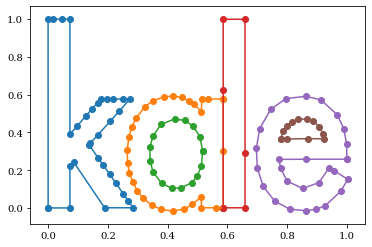

In [5]:
fnames = ['k', 'a1', 'a2', 'l', 'e1', 'e2']

xvals = []
yvals = []
for ff in fnames:
    fname = os.path.join(PATH_INPUT, ff + ".txt")
    xx, yy = np.loadtxt(fname, skiprows=1).T
    xx = np.append(xx, [xx[0]])
    yy = np.append(yy, [yy[0]])
    xvals.append(xx)
    yvals.append(yy)
    
    plt.scatter(xx, yy)
    plt.plot(xx, yy)    
    
plt.show()

## Draw Logo

In [6]:
def figax():
    fig, ax = plt.subplots(figsize=[6, 4])
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    return fig, ax


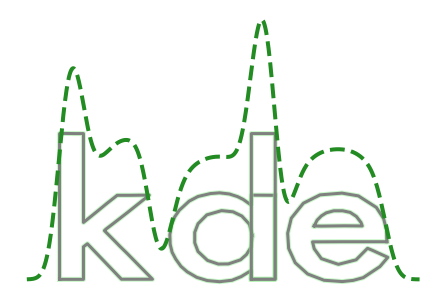

Saved to '/Users/lzkelley/Programs/kalepy/docs/logo/media/test_anim_001.png'


'/Users/lzkelley/Programs/kalepy/docs/logo/media/test_anim_001.png'

In [7]:
c1 = 'forestgreen'
c2 = 'darkgreen'
# colors = [c1, c2, c2, c1, c2, c2]
c3 = '0.5'
ckde = 'forestgreen'
colors = [c3, c3, c3, c3, c3, c3]


fig, ax = figax()

grid = np.linspace(-0.1, 1.1, 1000)

xnew = []
ynew = []

new_cuts = [
    np.arange(1, 15),
    [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 29, 30],
    [],
    [2, 3],
    [1, 2,  3,  4,  5,  6,  7,  8,  9],
    []
]

for ii, (xx, yy, cc) in enumerate(zip(xvals, yvals, colors)):
    if ii in [1, 2]:
        xx = xx + 0.072
    ax.plot(xx, yy, color='lightgreen', lw=5.0, alpha=0.5)
    ax.plot(xx, yy, color=cc, lw=3.0)
    
    if len(new_cuts[ii]) == 0:
        xnew.append([])
        ynew.append([])
        continue
        
    sel = new_cuts[ii]
    aa = xx[sel]
    bb = yy[sel]
    idx = np.argsort(aa)
    aa = aa[idx]
    bb = bb[idx]
    
    extr = kale.utils.minmax(aa)
    num = int(np.diff(extr)*100)
    xx = np.linspace(*extr, 100)
    yy = np.interp(xx, aa, bb)

    if ii == 3:
        yy = yy * 0.2
            
    xnew.append(xx)
    ynew.append(yy)
    
xx = np.concatenate(xnew)
yy = np.concatenate(ynew)
idx = np.argsort(xx)
xx = xx[idx]
yy = yy[idx]
kde = kale.KDE(xx, weights=yy, bw_rescale=0.3)
pdf = kde.pdf(grid)
ax.plot(grid, 0.9*pdf, color=ckde, ls='--', lw=4.0)

plt.show()
fname = 'test_anim_000.png'
save_fig(fig, fname, transparent=True)

## Animation

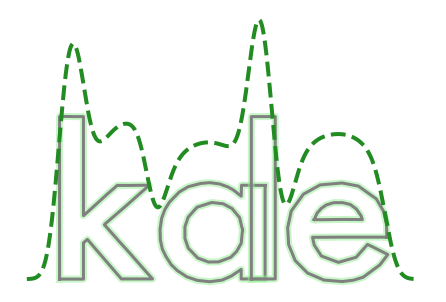

'/Users/lzkelley/Programs/kalepy/docs/logo/media/logo_00.png'

In [11]:
c1 = 'forestgreen'
c2 = 'darkgreen'
# colors = [c1, c2, c2, c1, c2, c2]
c3 = '0.5'
ckde = 'forestgreen'
colors = [c3, c3, c3, c3, c3, c3]


def draw_shift(shift, fname, show=False, close=True):
    fig, ax = figax()

    grid = np.linspace(-0.1, 1.1, 1000)

    xnew = []
    ynew = []

    new_cuts = [
        np.arange(1, 15),
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 29, 30],
        [],
        [2, 3],
        [1, 2,  3,  4,  5,  6,  7,  8,  9],
        []
    ]

    for ii, (xx, yy, cc) in enumerate(zip(xvals, yvals, colors)):
        if ii in [1, 2]:
            xx = xx + 0.072 + shift
        ax.plot(xx, yy, color='lightgreen', lw=7.0, alpha=0.5)
        ax.plot(xx, yy, color=cc, lw=3.0)

        if len(new_cuts[ii]) == 0:
            xnew.append([])
            ynew.append([])
            continue

        sel = new_cuts[ii]
        aa = xx[sel]
        bb = yy[sel]
        idx = np.argsort(aa)
        aa = aa[idx]
        bb = bb[idx]

        extr = kale.utils.minmax(aa)
        num = int(np.diff(extr)*100)
        xx = np.linspace(*extr, 100)
        yy = np.interp(xx, aa, bb)

        if ii == 3:
            yy = yy * 0.2

        xnew.append(xx)
        ynew.append(yy)

    xx = np.concatenate(xnew)
    yy = np.concatenate(ynew)
    idx = np.argsort(xx)
    xx = xx[idx]
    yy = yy[idx]
    kde = kale.KDE(xx, weights=yy, bw_rescale=0.3)
    pdf = kde.pdf(grid)
    ax.plot(grid, 0.9*pdf, color=ckde, ls='--', lw=4.0)

    # ax.set_ylim(-0.10569756676491791, 1.867648902063276)

    
    fname = save_fig(fig, fname, transparent=False, quiet=True)
    if show:
        plt.show()
    if close:
        plt.close('all')

    return fname
    
EXTR = [-0.1, 0.0]
NUM = 86
PAD = [4, 10]

# RUN THIS CODE TO PRODUCE EACH IMAGE FOR THE ANIMATION
# --------------------------------------------------------------------------------

# fname = 'anim_sigmoid_02_08/test_anim_000.png'
# curve = pad_ends(EXTR, NUM, lambda *xx: curve_sig(*xx, cut=[0.2, 0.8]), PAD)
# saved_fnames = []
# for ii in tqdm.tqdm_notebook(curve):
#     fn = draw_shift(ii, fname)
#     saved_fnames.append(fn)

# print("Saved {} files, e.g. '{}'".format(len(saved_fnames), saved_fnames[0]))

# GIF_COMMAND = "convert -fuzz 2% -layers Optimize -delay 5 anim/*.png anim.gif"
# print("Combine into gif with: \n\t'{}'")

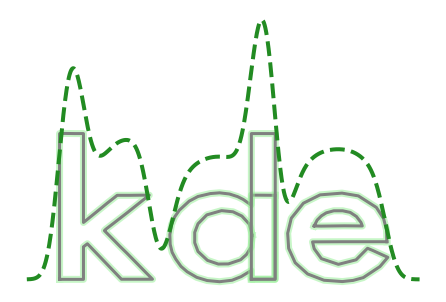

'/Users/lzkelley/Programs/kalepy/docs/logo/media/logo_01.png'

In [12]:
draw_shift(0.0, 'logo.png', close=False, show=True)

[-1.  1.]
[-1.  1.]
[-1.  1.]


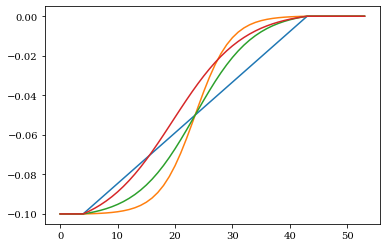

In [10]:
NUM = 40
EXTR = [-0.1, 0.0]

curves = [
    curve_lin,
    lambda *xx: curve_sig(*xx),
    lambda *xx: curve_sig(*xx, cut=[0.2, 0.8]),
    lambda *xx: curve_sig(*xx, cut=[0.3, 0.8]),
]


for ff in curves:
    # yy = ff(EXTR, NUM)
    yy = pad_ends(EXTR, NUM, ff, [4, 10])
    plt.plot(yy)

    
plt.show()